In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime
import logging
from requests.exceptions import RequestException
import os
import re
from typing import List, Dict, Optional

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("wafa_scraper.log"),
        logging.StreamHandler()
    ]
)

# Constants
CSV_FILE_NAME = "wafa_latest_news.csv"
BASE_URL_TEMPLATE = "https://english.wafa.ps/Pages/LastNews?pageNumber={}"  # 1-5
REQUEST_HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
    'Accept-Language': 'en-US,en;q=0.9',
}
REQUEST_TIMEOUT = 15

GAZA_TERMS = [
    "gaza", "north gaza", "south gaza", "central gaza", "gaza city", "deir al-balah",
    "khan younis", "rafah", "gaza strip", "palestinian enclave", "beach camp", "al-shati",
    "jabalia", "beit hanoun", "beit lahia", "al-zahra", "al-maghazi", "al-bureij",
    "nuseirat", "al-quds", "tuffah", "shuja'iyya", "remal", "daraj", "al-sabra",
    "al-tuffah", "al-nasr", "al-rijal", "al-katiba", "al-awda", "al-shifa"
]
WEST_BANK_TERMS = [
    "west bank", "jenin", "tubas", "tulkarm", "nablus", "naplouse", "nablus",
    "qalqilya", "salfit", "ramallah", "al-bireh", "jericho", "ariha",
    "bethlehem", "beit lahm", "hebron", "al-khalil", "jerusalem", "al-quds",
    "occupied territories", "silwan", "sheikh jarrah", "abu dis", "al-ram",
    "beitar illit", "ma'ale adumim", "ariel", "al-khalayleh", "al-azzariya",
    "al-eizariya", "beita", "huwara", "yatta", "al-samu", "al-arrub", "al-fawwar",
    "al-bireh", "biddu", "beitin", "burqa", "al-jalazun", "al-mazra'a", "President Abbas",
    "settler", "settlers", "colonist", "colonists",  "colonial", "colonialist", "colonialists"
]

ATTACK_KEYWORDS = [
    (["airstrike", "airstrikes", "air strike", "air strikes", "air raid", "air raids", 
      "bombardment", "shelling", "artillery", "missile", "missiles", "f16", "f-16", 
      "fighter jet", "fighter jets", "drone strike", "drone strikes", "drone", "drones", "helicopter", "jet", "air"], "airstrike"),
    (["demolish", "demolition", "demolitions", "bulldozer", "bulldozers", "bulldoze", 
      "home demolition", "house demolition", "structure demolition", "raze", "razing", 
      "destroyed home", "destroyed houses"], "demolition"),
    (["shoot", "shooting", "shot", "gunfire", "gun shot", "gun shots", "gunshot", 
      "gunshots", "live fire", "fired at", "fired upon", "open fire", "opened fire", 
      "sniper", "snipers"], "shooting"),
    (["bomb", "bombs", "bombing", "bombings", "explosion", "explosions", "explosive", 
      "exploded", "detonate", "detonation", "shell", "shells", "mortar", "mortars", 
      "grenade", "grenades"], "bomb"),
    (["raid", "raids", "military raid", "night raid", "search raid", "invasion", 
      "storm", "storming", "break in", "forced entry", "incursion", "incursions"], "raid"),
    (["settler", "settlers", "colonist", "colonists", "settler attack", "settler violence", 
      "settler aggression", "settler rampage", "settler riot", "settler pogrom",
      "colonial", "colonialist", "colonialists"], "settler"),
    (["arrest", "arrests", "detain", "detention", "detained", "kidnap", "abduct", 
      "abduction", "capture", "imprison", "imprisonment", "take into custody"], "arrest"),
    (["blockade", "siege", "closure", "checkpoint", "checkpoints", "barrier", 
      "curfew", "movement restriction", "travel ban", "access denied"], "restriction"),
    (["genocide", "ethic cleansing", "force displacement", "starvation"], "crimes against humanity"),
]

EVENT_KEYWORDS = {
    "Killings": [
        "kill", "killed", "killing", "death", "deaths", "die", "died", "dead", 
        "fatality", "fatalities", "slain", "murder", "murdered", "massacre", 
        "execute", "executed", "execution", "martyr", "martyrs", "martyrdom",
        "assassinate", "assassination", "slaughter", "mass killing", "genocide",
        "ethnic cleansing", "lost their lives", "were killed", "found dead", "succumb", "succumbs"
    ],
    
    "Injury": [
        "injure", "injured", "injury", "injuries", "wound", "wounded", "wounds",
        "hurt", "maim", "maimed", "critical condition", "seriously hurt", "hospitalized",
        "amputee", "amputation", "bleeding", "trauma", "shrapnel", "fracture",
        "burn", "burns", "medical attention", "treated for wounds", "sustained injuries"
    ],
    
    "Displacement": [
        "displace", "displaced", "evacuate", "evacuated", "eviction", "expel",
        "expelled", "forced out", "flee", "fled", "flight", "refugee", "refugees",
        "idp", "internally displaced", "homeless", "lost their home", "house destroyed",
        "shelter", "makeshift shelter", "tent", "tents", "camp", "camps", "exodus", "displacement"
    ],
    
    "Demonstration": [
        "protest", "protests", "protestor", "protestors", "demonstration", 
        "demonstrations", "march", "marches", "rally", "rallies", "sit-in",
        "strike", "general strike", "day of rage", "clash", "clashes", "confrontation",
        "confrontations", "resistance", "solidarity", "mobilization", "gathering",
        "gatherings", "vigil", "vigils", "civil disobedience", "popular resistance"
    ],
    
    "Children": [
        "child", "children", "minor", "minors", "boy", "boys", "girl", "girls",
        "baby", "babies", "infant", "infants", "toddler", "toddlers", "teen", "teens",
        "teenager", "teenagers", "youth", "youngster", "youngsters", "schoolchild",
        "schoolchildren", "kindergarten", "pediatric", "newborn", "newborns", "underage"
    ],
    
    "Hostages": [
        "hostage", "hostages", "captive", "captives", "prisoner", "prisoners",
        "detainee", "detainees", "abductee", "abductees", "kidnap victim", 
        "held captive", "being held", "in custody", "unlawful detention",
        "illegal detention", "political prisoner", "administrative detention"
    ],
    
    "Medical Infrastructure": [
        "hospital", "hospitals", "clinic", "clinics", "medical center", 
        "health facility", "ambulance", "ambulances", "paramedic", "paramedics",
        "doctor", "doctors", "nurse", "nurses", "physician", "physicians",
        "medical staff", "health worker", "health workers", "icu", "emergency room",
        "er", "operating room", "medical supplies", "medicine shortage",
        "pharmacy", "pharmacies", "red crescent", "medical aid", "field hospital",
        "mobile clinic", "vaccination", "vaccine", "vaccines", "medication",
        "medications", "treatment", "treatments", "surgery", "surgeries",
        "medical equipment", "oxygen", "ventilator", "ventilators"
    ],
    
    "Education": [
        "school", "schools", "university", "universities", "college", "colleges",
        "kindergarten", "kindergartens", "students", "teachers", "education",
        "educational", "academic", "classroom", "classrooms", "textbook",
        "textbooks", "curriculum", "scholar", "scholars", "professor",
        "professors", "lecturer", "lecturers", "student union", "tuition",
        "scholarship", "scholarships", "educational materials", "school supplies"
    ],
    
    "Infrastructure": [
        "electricity", "power plant", "power grid", "water supply", "sewage",
        "sanitation", "roads", "bridge", "bridges", "tunnel", "tunnels",
        "communication", "internet", "telecom", "telecommunications", "network",
        "networks", "construction", "rebuilding", "reconstruction", "repair",
        "repairs", "damage", "destroyed infrastructure", "public works",
        "housing", "homes", "apartment", "apartments", "building", "buildings"
    ],
    
    "Food Security": [
        "hunger", "starvation", "famine", "malnutrition", "food shortage",
        "food aid", "humanitarian aid", "relief", "food supplies", "rations",
        "nutrition", "undernourished", "food insecurity", "food distribution",
        "food parcels", "food packages", "humanitarian corridor", "aid convoy",
        "blockade", "siege", "access restrictions", "humanitarian access"
    ],
    
    "Legal": [
        "court", "courts", "judge", "judges", "lawyer", "lawyers", "attorney",
        "attorneys", "trial", "trials", "verdict", "verdicts", "ruling",
        "rulings", "appeal", "appeals", "lawsuit", "lawsuits", "legal action",
        "legal proceedings", "international law", "human rights", "war crimes",
        "crime against humanity", "icc", "international criminal court",
        "investigation", "investigations", "probe", "inquiry", "inquiries", "ICJ"
    ],

    "Religion": [
        "Mosque", "Church", "Tomb", "Christians", "Muslims", "Muslim", "Christian", "Joseph's"
    ],

    "Theft": ["steal"
    ],

    "United Nations": ["UN", "United Nations", "UNRWA", "Security Council"
    ],

    "Hamas": ["Hamas"],

    "Palestine Authority": ["President Abbas", "Palestine Authority", "Fatah", "Palestinian National Authority"], 
    

}

ARTICLE_SELECTORS = [
    ("div", "post-wrap"),
    ("article", None),
    ("div", "news-item"),
    ("div", "article"),
    ("li", "news-list-item")
]

def get_webpage_content(url: str) -> Optional[bytes]:
    try:
        response = requests.get(url, headers=REQUEST_HEADERS, timeout=REQUEST_TIMEOUT)
        response.raise_for_status()
        if not response.content or len(response.content) < 500:
            logging.warning(f"Page content seems too small: {len(response.content)} bytes")
            return None
        return response.content
    except RequestException as e:
        logging.error(f"Failed to fetch webpage {url}: {e}")
        return None

def find_articles(soup: BeautifulSoup) -> List:
    for tag, class_name in ARTICLE_SELECTORS:
        try:
            if class_name:
                articles = soup.find_all(tag, class_=class_name)
            else:
                articles = soup.find_all(tag)
            if articles:
                logging.info(f"Found {len(articles)} articles with selector {tag}.{class_name if class_name else '*'}")
                return articles
        except Exception as e:
            logging.warning(f"Error with selector {tag}.{class_name}: {e}")
    logging.warning("No articles found with any selector!")
    return []

def contains_any(text: str, keywords: List[str]) -> bool:
    if not isinstance(text, str):
        return False
    text = text.lower()
    return any(
        re.search(r'\b' + re.escape(word.lower()) + r'\b', text) 
        for word in keywords
    )

def extract_events(headline: str) -> str:
    labels = []
    for label, keywords in EVENT_KEYWORDS.items():
        if contains_any(headline, keywords):
            labels.append(label)
    labels = list(dict.fromkeys(labels))
    return ', '.join(labels) if labels else "Not Coded"

def extract_article_data(article) -> Dict:
    data = {
        "Date": "",
        "Time": "",
        "Headline": "",
        "URL": "",
        "Location": "",
        "Attack": "Not Coded",
        "Events": "Not Coded"
    }
    relative_url = ""
    headline_tag = article.find(["h1", "h2", "h3", "h4", "h5", "h6", "a"])
    if headline_tag:
        if headline_tag.name == "a":
            data["Headline"] = headline_tag.get_text(strip=True)
            relative_url = headline_tag["href"]
        else:
            data["Headline"] = headline_tag.get_text(strip=True)
            a_tag = headline_tag.find("a")
            if a_tag and a_tag.has_attr("href"):
                relative_url = a_tag["href"]
        if relative_url and not relative_url.startswith("http"):
            data["URL"] = f"https://english.wafa.ps{relative_url}"
        elif relative_url:
            data["URL"] = relative_url
    date_time_tag = article.find(["span", "div", "time"], class_=re.compile(r"date|time|meta", re.I))
    if date_time_tag:
        date_time_text = date_time_tag.text.strip()
        try:
            for fmt in ("%d/%B/%Y %I:%M %p", "%Y-%m-%d %H:%M:%S", "%B %d, %Y", "%d-%m-%Y"):
                try:
                    date_time_obj = datetime.strptime(date_time_text, fmt)
                    data["Date"] = date_time_obj.strftime("%Y-%m-%d")
                    data["Time"] = date_time_obj.strftime("%H:%M:%S")
                    break
                except ValueError:
                    continue
        except Exception as e:
            logging.warning(f"Could not parse date: {date_time_text} - {e}")
    headline_lower = data["Headline"].lower()
    # Location: ensure "Gaza" and "West Bank" are capitalized exactly
    for term in GAZA_TERMS:
        if term in headline_lower:
            data["Location"] = "Gaza"
            break
    if not data["Location"]:
        for term in WEST_BANK_TERMS:
            if term in headline_lower:
                data["Location"] = "West Bank"
                break
    # Attack: if not found, stays "Not Coded"
    for keywords, attack_type in ATTACK_KEYWORDS:
        if any(re.search(r'\b' + re.escape(kw) + r'\b', headline_lower) for kw in keywords):
            data["Attack"] = attack_type
            break
    data["Events"] = extract_events(data["Headline"])
    return data

def scrape_page(page_num: int) -> List[Dict]:
    url = BASE_URL_TEMPLATE.format(page_num)
    logging.info(f"Scraping page {page_num}: {url}")
    content = get_webpage_content(url)
    if not content:
        return []
    soup = BeautifulSoup(content, "html.parser")
    articles = find_articles(soup)
    scraped_data = []
    for article in articles:
        try:
            article_data = extract_article_data(article)
            if article_data["Headline"]:
                scraped_data.append(article_data)
        except Exception as e:
            logging.error(f"Error processing article: {e}")
            continue
    logging.info(f"Page {page_num}: Extracted {len(scraped_data)} articles")
    return scraped_data

def save_to_csv(data: List[Dict], filename: str) -> bool:
    if not data:
        logging.warning("No data to save!")
        return False
    df = pd.DataFrame(data)
    columns = ["Date", "Time", "Headline", "URL", "Location", "Attack", "Events"]
    for col in columns:
        if col not in df.columns:
            df[col] = ""
    df = df[columns]
    # Fill empty/blank Attack cells with "Not Coded"
    df['Attack'] = df['Attack'].replace('', 'Not Coded')
    # Ensure Location is exactly "Gaza", "West Bank", or blank
    df['Location'] = df['Location'].apply(lambda x: "Gaza" if x.lower() == "gaza" else ("West Bank" if x.lower() == "west bank" else ""))
    # Sort by Date descending (newest first)
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.sort_values(by='Date', ascending=False)
    # Handle existing file
    if os.path.exists(filename):
        try:
            existing_df = pd.read_csv(filename)
            existing_df['Date'] = pd.to_datetime(existing_df['Date'], errors='coerce')
            combined_df = pd.concat([existing_df, df], ignore_index=True)
            combined_df = combined_df.drop_duplicates(
                subset=["Headline", "Date"], 
                keep="last"
            )
            combined_df["Events"] = combined_df.apply(
                lambda row: extract_events(row["Headline"]),
                axis=1
            )
            # Fill empty/blank Attack cells with "Not Coded"
            combined_df['Attack'] = combined_df['Attack'].replace('', 'Not Coded')
            # Ensure Location is exactly "Gaza", "West Bank", or blank
            combined_df['Location'] = combined_df['Location'].apply(lambda x: "Gaza" if str(x).lower() == "gaza" else ("West Bank" if str(x).lower() == "west bank" else ""))
            # Sort newest first
            combined_df = combined_df.sort_values(by='Date', ascending=False)
            df = combined_df
        except Exception as e:
            logging.error(f"Error merging with existing file: {e}")
            return False
    try:
        df.to_csv(filename, index=False, encoding='utf-8-sig')
        logging.info(f"Saved {len(df)} articles to {filename}")
        return True
    except Exception as e:
        logging.error(f"Failed to save CSV: {e}")
        return False

def scrape_and_export_csv():
    all_data = []
    for page_num in range(1, 6):
        try:
            page_data = scrape_page(page_num)
            all_data.extend(page_data)
        except Exception as e:
            logging.error(f"Error scraping page {page_num}: {e}")
            continue
    if not save_to_csv(all_data, CSV_FILE_NAME):
        logging.error("Failed to save data to CSV")
        return False
    return True

if __name__ == "__main__":
    scrape_and_export_csv()


2025-04-17 04:16:57,765 - INFO - Scraping page 1: https://english.wafa.ps/Pages/LastNews?pageNumber=1
2025-04-17 04:16:58,947 - INFO - Found 50 articles with selector div.post-wrap
2025-04-17 04:16:58,994 - INFO - Page 1: Extracted 50 articles
2025-04-17 04:16:58,994 - INFO - Scraping page 2: https://english.wafa.ps/Pages/LastNews?pageNumber=2
2025-04-17 04:17:00,109 - INFO - Found 50 articles with selector div.post-wrap
2025-04-17 04:17:00,148 - INFO - Page 2: Extracted 50 articles
2025-04-17 04:17:00,148 - INFO - Scraping page 3: https://english.wafa.ps/Pages/LastNews?pageNumber=3
2025-04-17 04:17:01,262 - INFO - Found 50 articles with selector div.post-wrap
2025-04-17 04:17:01,293 - INFO - Page 3: Extracted 50 articles
2025-04-17 04:17:01,293 - INFO - Scraping page 4: https://english.wafa.ps/Pages/LastNews?pageNumber=4
2025-04-17 04:17:02,383 - INFO - Found 50 articles with selector div.post-wrap
2025-04-17 04:17:02,425 - INFO - Page 4: Extracted 50 articles
2025-04-17 04:17:02,425 

Location Table:
 Location  Count
     Gaza     45
West Bank     48
Not Coded     50

Attack Table:
                 Attack  Count
              Not Coded     64
              airstrike     22
                settler     16
                   raid     13
                   bomb      7
               shooting      6
             demolition      4
crimes against humanity      3
                 arrest      2

Event Table:
                 Event  Count
             Not Coded     49
              Killings     31
                Injury     23
Medical Infrastructure     11
        United Nations     10
          Displacement      9
              Religion      9
         Demonstration      8
              Children      6
         Food Security      5
   Palestine Authority      4
              Hostages      3
        Infrastructure      3
             Education      2
                 Legal      2
                 Theft      1


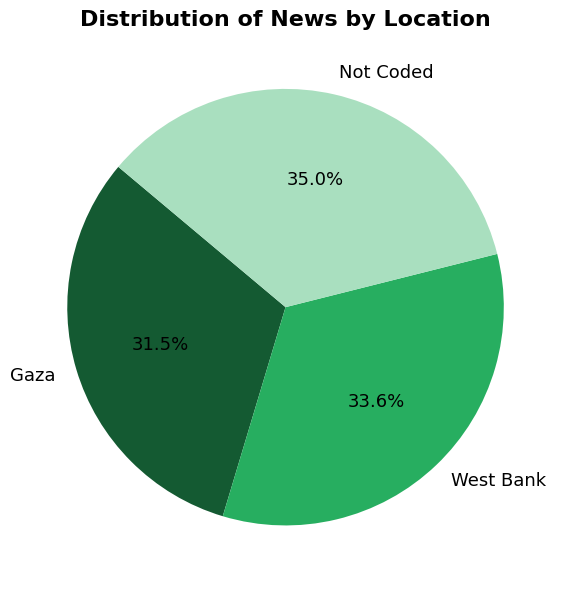

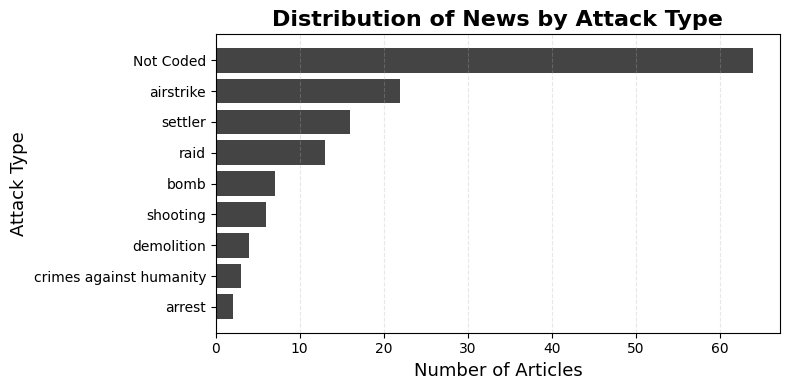

In [5]:
# --- HORIZONTAL BAR CHART: Attack ---
df['Attack_Coded'] = df['Attack'].replace('', 'Not Coded')
attack_counts = df['Attack_Coded'].value_counts().sort_values()

plt.figure(figsize=(8,4), facecolor='white')
plt.barh(attack_counts.index, attack_counts.values, color='#444444')
plt.xlabel('Number of Articles', fontsize=13)
plt.ylabel('Attack Type', fontsize=13)
plt.title('Distribution of News by Attack Type', fontsize=16, weight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


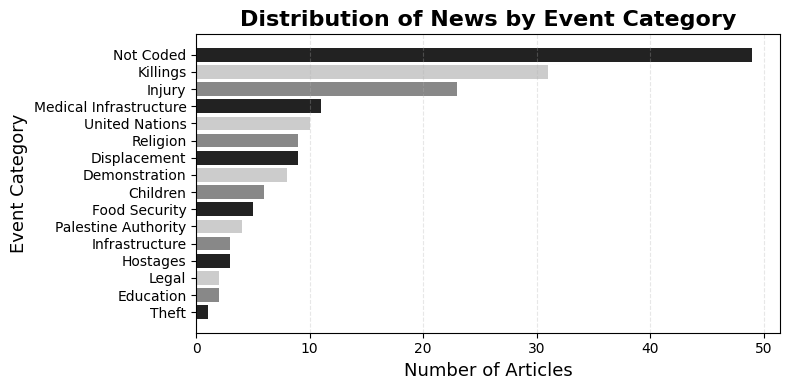

In [13]:
# --- HORIZONTAL BAR CHART: Events ---
def split_events(events):
    if pd.isna(events) or str(events).strip() == '' or str(events).strip().lower() == 'not coded':
        return ['Not Coded']
    return [e.strip() for e in str(events).split(',') if e.strip()]

event_list = df['Events'].apply(split_events).tolist()
flat_events = [event for sublist in event_list for event in sublist]
event_counts = pd.Series(Counter(flat_events)).sort_values()

plt.figure(figsize=(8,4), facecolor='white')
plt.barh(event_counts.index, event_counts.values, color=['#222222', '#888888', '#cccccc', '#222222', '#888888', '#cccccc'][:len(event_counts)])
plt.xlabel('Number of Articles', fontsize=13)
plt.ylabel('Event Category', fontsize=13)
plt.title('Distribution of News by Event Category', fontsize=16, weight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [19]:
import pandas as pd

# Load your data
df = pd.read_csv('wafa_latest_news.csv')

# --- Location Table ---
def normalize_location(x):
    if pd.isna(x) or str(x).strip() == '':
        return 'Not Coded'
    if str(x).strip().lower() == 'gaza':
        return 'Gaza'
    if str(x).strip().lower() == 'west bank':
        return 'West Bank'
    return 'Not Coded'

df['Location_Coded'] = df['Location'].apply(normalize_location)
location_table = df['Location_Coded'].value_counts().reindex(['Gaza', 'West Bank', 'Not Coded'], fill_value=0).reset_index()
location_table.columns = ['Location', 'Count']

# --- Attack Table ---
df['Attack_Coded'] = df['Attack'].replace('', 'Not Coded')
attack_table = df['Attack_Coded'].value_counts().reset_index()
attack_table.columns = ['Attack', 'Count']

# --- Events Table (handles multiple events per article) ---
def split_events(events):
    if pd.isna(events) or str(events).strip() == '' or str(events).strip().lower() == 'not coded':
        return ['Not Coded']
    return [e.strip() for e in str(events).split(',') if e.strip()]

df['Events_List'] = df['Events'].apply(split_events)
df_exploded = df.explode('Events_List')
event_table = df_exploded['Events_List'].value_counts().reset_index()
event_table.columns = ['Event', 'Count']

# --- Styling function ---
def pretty_styler(df, caption):
    return (df.style
        .set_caption(caption)
        .set_table_styles([
            {'selector': 'th', 'props': [('background-color', '#145A32'), ('color', 'white'), ('font-weight', 'bold'), ('text-align', 'center'), ('font-size', '15px')]},
            {'selector': 'td', 'props': [('text-align', 'center'), ('font-size', '13px')]},
            {'selector': 'caption', 'props': [('caption-side', 'top'), ('font-size', '16px'), ('font-weight', 'bold'), ('color', '#145A32')]}
        ])
        .set_properties(**{'border': '1px solid #27AE60', 'width': '120px', 'height': '35px', 'text-align': 'center'})
        .hide(axis="index")
    )

# --- Display tables prettily (in notebook/Jupyter/HTML) ---
pretty_styler(location_table, "Location Summary Table")

Location,Count
Gaza,45
West Bank,48
Not Coded,50


In [20]:
pretty_styler(attack_table, "Attack Summary Table")

Attack,Count
Not Coded,64
airstrike,22
settler,16
raid,13
bomb,7
shooting,6
demolition,4
crimes against humanity,3
arrest,2


In [21]:
pretty_styler(event_table, "Event Summary Table")


Event,Count
Not Coded,49
Killings,31
Injury,23
Medical Infrastructure,11
United Nations,10
Displacement,9
Religion,9
Demonstration,8
Children,6
Food Security,5
